In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn


In [3]:
df_abalone = pd.read_csv('data/abalone.csv')
df_abalone.head()

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error 
df_train, df_test = train_test_split(
    pd.get_dummies(df_abalone, columns=['Sex']),
    train_size=0.8,
    random_state=123
)
X_cols = [col for col in df_train.columns if col != 'Rings']

In [11]:
len(df_train)

3341

In [13]:
len(df_train.index.unique())

3341

In [5]:
# Bootstrap

# replace=True로 하면 복원추출 방식으로 표본을 뽑습니다
df_bootstrap = df_train.sample(frac=1.0, replace=True, random_state=123)
df_bootstrap.index.nunique() / len(df_train)

0.6357378030529781

In [12]:
len(df_bootstrap)

3341

In [14]:
len(df_bootstrap.index.unique())

2129

In [10]:
from sklearn.tree import DecisionTreeRegressor

# out-of-bag prediction
df_oob_prds = []
# 앙상블에 활용되는 모델들
models = [] 
n_estimators_range = np.arange(1, 101)
for i in n_estimators_range:
    # bootstrap (복원추출)
    df_bootstrap = df_train.sample(frac=1.0, replace=True) # Bootstrap
    # out-of-bag 표본 = bootstrap에서 선택되지 않은 표본
    df_oob = df_train.loc[~df_train.index.isin(df_bootstrap.index.unique())]
    # decision tree 이용
    reg_dt = DecisionTreeRegressor()
    reg_dt.fit(df_bootstrap[X_cols], df_bootstrap['Rings'])
    models.append(reg_dt)
    
    # 학습에 사용되지 않은 sample이기 때문에 이를 통해 predict
    df_oob_prds.append(
        pd.Series(reg_dt.predict(df_oob[X_cols]), index=df_oob.index, name=i)
    )

[2746    11.0
 853     10.0
 1199    12.0
 1156     9.0
 2940     8.0
         ... 
 2050    10.0
 1092     9.0
 96      12.0
 4060     9.0
 3582     9.0
 Name: 1, Length: 1225, dtype: float64,
 853     10.0
 3419     9.0
 1417    11.0
 1156     8.0
 3869    19.0
         ... 
 3481     8.0
 111     11.0
 4169     7.0
 1593     7.0
 4060     9.0
 Name: 2, Length: 1275, dtype: float64,
 853     15.0
 2500    15.0
 2692    10.0
 3986    15.0
 4083     9.0
         ... 
 1092     7.0
 1363     8.0
 111     12.0
 96      15.0
 1346    13.0
 Name: 3, Length: 1223, dtype: float64,
 3419     9.0
 2500    21.0
 1417    14.0
 1156     9.0
 3869    19.0
         ... 
 2894    10.0
 942      8.0
 4143    11.0
 4060     8.0
 1346    12.0
 Name: 4, Length: 1228, dtype: float64,
 2746     6.0
 1199    10.0
 2500    12.0
 1417    13.0
 3869     8.0
         ... 
 1363     8.0
 4060     9.0
 1346    14.0
 3454    11.0
 3582    11.0
 Name: 5, Length: 1229, dtype: float64,
 3419    11.0
 1199     9.0
 2

In [18]:
df_train_prds = pd.concat([
    pd.Series(model.predict(df_train[X_cols]), index=df_train.index, name=i)
    for i, model in enumerate(models)
], axis=1)
df_test_prds = pd.concat([
    pd.Series(model.predict(df_test[X_cols]), index=df_test.index, name=i)
    for i, model in enumerate(models)
], axis=1)
df_oob_prds = pd.concat(df_oob_prds, axis=1)

In [20]:
display(df_train_prds)
display(df_test_prds)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2746,11.0,8.0,8.0,8.0,6.0,8.0,8.0,8.0,8.0,8.0,...,8.0,8.0,8.0,8.0,8.0,6.0,8.0,8.0,8.0,13.0
853,10.0,10.0,15.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,...,9.0,9.0,9.0,9.0,9.0,10.0,9.0,9.0,9.0,9.0
1809,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,8.0,8.0,10.0,8.0,9.0,8.0,8.0,11.0,8.0,9.0
3419,8.0,9.0,8.0,9.0,8.0,11.0,8.0,8.0,8.0,8.0,...,8.0,10.0,8.0,8.0,8.0,8.0,9.0,8.0,8.0,6.0
1199,12.0,10.0,10.0,10.0,10.0,9.0,9.0,14.0,10.0,10.0,...,11.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,8.0,7.0,8.0,8.0,8.0,8.0,8.0,8.0,11.0,9.0,...,8.0,8.0,8.0,8.0,8.0,8.0,9.0,7.0,9.0,8.0
4060,9.0,9.0,8.0,8.0,9.0,8.0,8.0,8.0,8.0,8.0,...,8.0,8.0,8.0,8.0,13.0,8.0,8.0,9.0,8.0,8.0
1346,8.0,8.0,13.0,12.0,14.0,8.0,8.0,8.0,8.0,20.0,...,8.0,8.0,14.0,8.0,8.0,14.0,8.0,8.0,8.0,8.0
3454,8.0,8.0,8.0,8.0,11.0,9.0,7.0,12.0,8.0,8.0,...,8.0,8.0,8.0,8.0,8.0,8.0,10.0,14.0,8.0,8.0


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2812,4.0,4.0,5.0,3.0,5.0,4.0,6.0,6.0,6.0,5.0,...,5.0,3.0,5.0,4.0,5.0,3.0,6.0,6.0,6.0,6.0
1344,9.0,9.0,10.0,9.0,11.0,10.0,11.0,10.0,10.0,15.0,...,9.0,9.0,10.0,12.0,10.0,12.0,8.0,11.0,10.0,11.0
533,9.0,8.0,7.0,7.0,8.0,8.0,10.0,9.0,6.0,7.0,...,8.0,7.0,11.0,12.0,9.0,7.0,7.0,13.0,7.0,8.0
866,17.0,8.0,14.0,10.0,14.0,13.0,14.0,19.0,13.0,14.0,...,9.0,13.0,9.0,17.0,12.0,14.0,10.0,20.0,13.0,15.0
3939,13.0,17.0,15.0,12.0,11.0,13.0,10.0,10.0,14.0,18.0,...,13.0,11.0,10.0,10.0,14.0,10.0,10.0,13.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,14.0,10.0,10.0,10.0,9.0,9.0,11.0,15.0,9.0,15.0,...,15.0,15.0,9.0,9.0,8.0,11.0,8.0,18.0,8.0,11.0
3724,16.0,8.0,13.0,8.0,8.0,12.0,10.0,9.0,11.0,9.0,...,9.0,9.0,8.0,16.0,8.0,10.0,8.0,8.0,8.0,17.0
1203,11.0,11.0,11.0,11.0,11.0,10.0,11.0,10.0,11.0,11.0,...,13.0,11.0,9.0,11.0,10.0,12.0,13.0,13.0,11.0,12.0
3889,20.0,10.0,14.0,17.0,13.0,18.0,19.0,22.0,10.0,17.0,...,10.0,23.0,14.0,14.0,16.0,12.0,20.0,17.0,22.0,14.0


In [22]:
# estimator의 개수에 따라 variance가 줄어드는 것을 관찰할 수 있음
s_train_prd_var = [df_train_prds.iloc[:, :i].mean(axis=1).var() for i in range(1, 101)]
# 정답과 예측값의 차이가 얼마나 줄어드는지 관찰할 수 있음
s_test_mse = [mean_squared_error(df_test['Rings'], df_test_prds.iloc[:, :i].mean(axis=1)) for i in range(1, 101)]

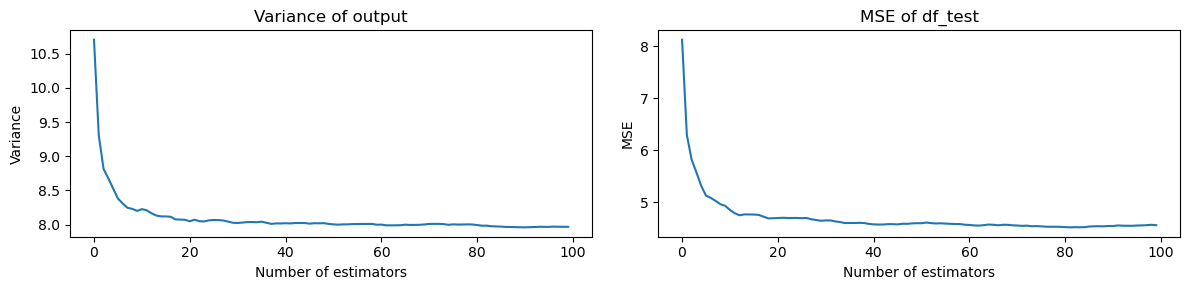

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(s_train_prd_var)
axes[0].set_title('Variance of output')
axes[0].set_xlabel('Number of estimators')
axes[0].set_ylabel('Variance')
axes[1].plot(s_test_mse)
axes[1].set_title('MSE of df_test')
axes[1].set_xlabel('Number of estimators')
axes[1].set_ylabel('MSE')
plt.tight_layout()

In [29]:
from sklearn.ensemble import BaggingRegressor 
from sklearn.tree import DecisionTreeRegressor

# train set은 고정하고 n_estimator 수, max_leaf_nodes를 매개변수로
mse_train, mse_test = dict(), dict() 
prd_train_var = dict() 
n_estimators_list = [1, 3, 5, 10, 25, 50]
max_leaf_nodes_list = [4, 8, 16, 32, 64, 96, 128, 160, 192, 256, 384, 512]
for j in n_estimators_list:
    mse_train[j], mse_test[j], prd_train_var[j] = list(), list(), list() 
    for i in max_leaf_nodes_list:
        reg_bagg = BaggingRegressor(
            DecisionTreeRegressor(max_leaf_nodes=i),
            n_estimators=j,
            random_state=123
        )
    
        reg_bagg.fit(df_train[X_cols], df_train['Rings'])
        prd_train = reg_bagg.predict(df_train[X_cols])
        prd_train_var[j].append(prd_train.var())
        
        mse_train[j].append(mean_squared_error(df_train['Rings'], prd_train))
        mse_test[j].append(mean_squared_error(df_test['Rings'], reg_bagg.predict(df_test[X_cols])))

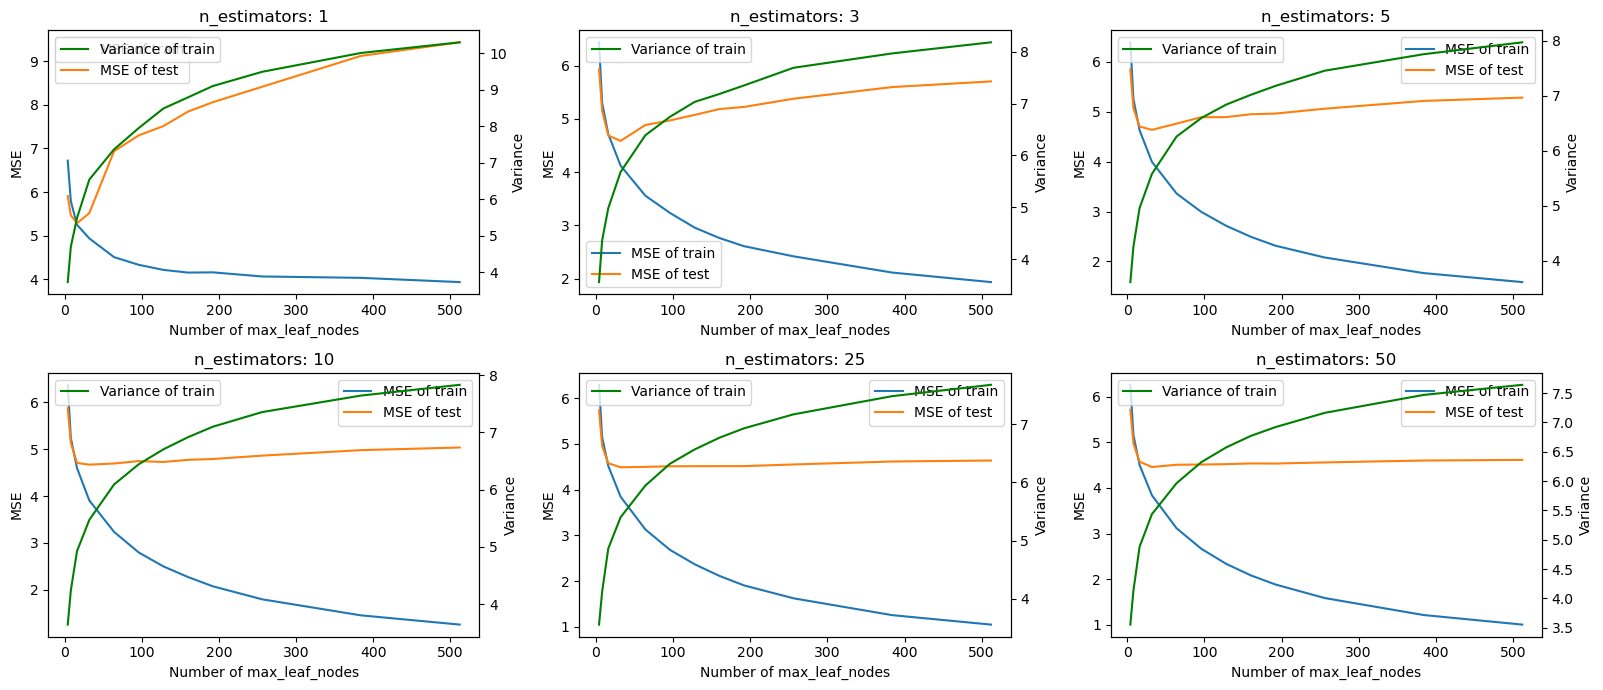

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(16, 7))
for i, ax in zip(n_estimators_list, axes.ravel()):
    ax.plot(max_leaf_nodes_list, mse_train[i], label='MSE of train')
    ax.plot(max_leaf_nodes_list, mse_test[i], label='MSE of test')
    ax.set_xlabel('Number of max_leaf_nodes')
    ax.set_ylabel('MSE')
    tax = ax.twinx()
    tax.plot(max_leaf_nodes_list, prd_train_var[i], color='green', label='Variance of train')
    tax.set_ylabel('Variance')
    ax.legend()
    tax.legend()
    ax.set_title('n_estimators: {}'.format(i))
plt.tight_layout()
plt.show()

In [43]:
df_abalone['Class'] = (df_abalone['Sex'] == 'I').apply(lambda x : -1 if x else 1)

In [49]:
df_train, df_test = train_test_split(df_abalone, train_size=0.8, random_state=123)
X_cols = [col for col in df_train.columns if col != 'Class' and col != 'Sex']
X_cols

['Length',
 'Diameter',
 'Height',
 'Whole',
 'Shucked',
 'Viscera',
 'Shell',
 'Rings']

In [51]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import roc_auc_score

roc_train, roc_test = dict(), dict()
n_estimators_list = [1, 3, 5, 10, 25, 50]
max_leaf_nodes_list = [4, 8, 16, 32, 64, 96, 128, 160, 192, 256, 384, 512]
for j in n_estimators_list:
    roc_train[j], roc_test[j], prd_train_var[j] = list(), list(), list()
    for i in max_leaf_nodes_list:
        clf_ab = AdaBoostClassifier(
            DecisionTreeClassifier(max_leaf_nodes=i),
            n_estimators=j,
            random_state=123
        )
        
        clf_ab.fit(df_train[X_cols], df_train['Class'])
        prd_train = clf_ab.decision_function(df_train[X_cols])
        prd_train_var[j].append(prd_train.var())
        
        roc_train[j].append(roc_auc_score(df_train['Class'], prd_train))
        roc_test[j].append(roc_auc_score(df_test['Class'], clf_ab.decision_function(df_test[X_cols])))
        

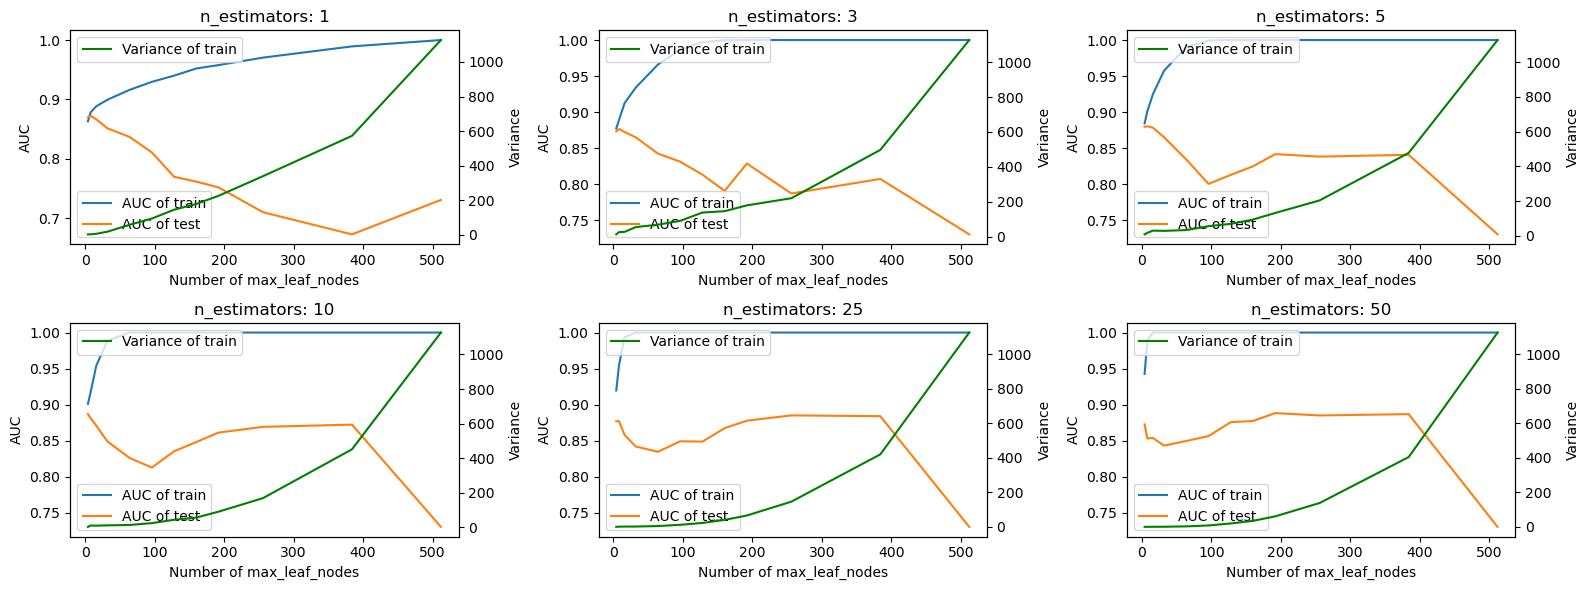

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(16, 6))
for i, ax in zip(n_estimators_list, axes.ravel()):
    ax.plot(max_leaf_nodes_list, roc_train[i], label='AUC of train')
    ax.plot(max_leaf_nodes_list, roc_test[i], label='AUC of test')
    ax.set_xlabel('Number of max_leaf_nodes')
    ax.set_ylabel('AUC')
    tax = ax.twinx()
    tax.plot(max_leaf_nodes_list, prd_train_var[i], color='green', label='Variance of train')
    tax.set_ylabel('Variance')
    ax.legend()
    tax.legend()
    ax.set_title('n_estimators: {}'.format(i))
plt.tight_layout()
plt.show()

In [53]:
from sklearn.ensemble import GradientBoostingRegressor

mse_train, mse_test = dict(), dict()
prd_train_var = dict()
n_estimators_list = [25, 50, 100, 200, 300, 500]
max_leaf_nodes_list = [4,  6, 8, 10, 13, 16]
for j in n_estimators_list:
    mse_train[j], mse_test[j], prd_train_var[j] = list(), list(), list()
    for i in max_leaf_nodes_list:
        reg_gb = GradientBoostingRegressor(
            max_leaf_nodes=i,
            n_estimators=j,
            random_state=123,
            learning_rate = 1e-2
        )

        reg_gb.fit(df_train[X_cols], df_train['Rings'])
        prd_train = reg_gb.predict(df_train[X_cols])
        prd_train_var[j].append(prd_train.var())
        mse_train[j].append(mean_squared_error(df_train['Rings'], prd_train))
        mse_test[j].append(mean_squared_error(df_test['Rings'], reg_gb.predict(df_test[X_cols])))

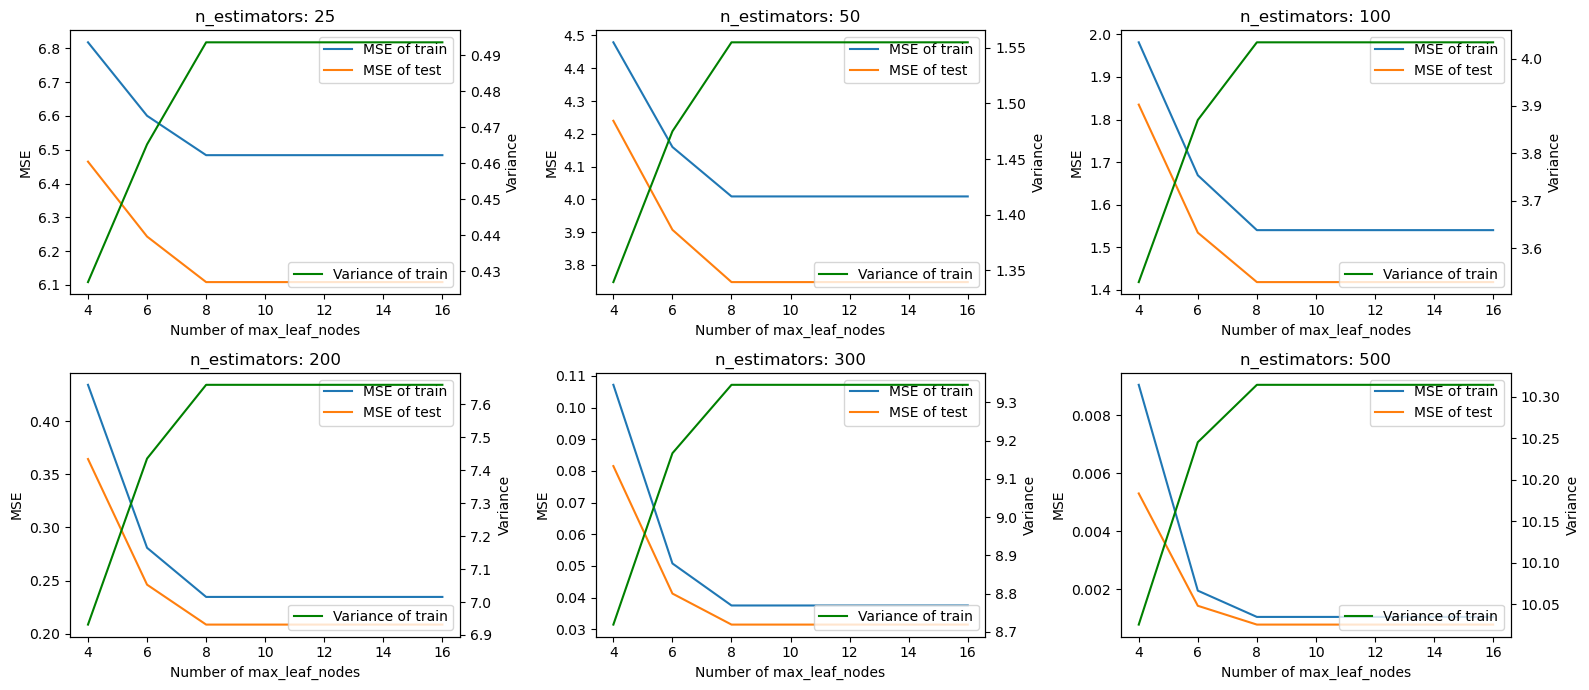

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(16, 7))
for i, ax in zip(n_estimators_list, axes.ravel()):
    ax.plot(max_leaf_nodes_list, mse_train[i], label='MSE of train')
    ax.plot(max_leaf_nodes_list, mse_test[i], label='MSE of test')
    ax.set_xlabel('Number of max_leaf_nodes')
    ax.set_ylabel('MSE')
    tax = ax.twinx()
    tax.plot(max_leaf_nodes_list, prd_train_var[i], color='green', label='Variance of train')
    tax.set_ylabel('Variance')
    ax.legend()
    tax.legend()
    ax.set_title('n_estimators: {}'.format(i))
plt.tight_layout()
plt.show()

In [55]:
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate

# 5-fold Cross Validation을 5번 수행토록 Splitter를 설정합니다.
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)

def eval_model(name, clf):
    """
    Parameters:
        name: 모델 명칭
        clf: 모델 인스턴스
    Returns:
        Series, 'test'의 roc_auc와 'train'의 roc_auc를 보입니다.
    """
    result = cross_validate(clf, df_train[X_cols], df_train['Class'], cv=cv, scoring='roc_auc', return_train_score=True)
    return pd.Series([
        '{:.3f}±{:.3f}'.format(result['test_score'].mean(), result['test_score'].std()), 
        '{:.3f}±{:.3f}'.format(result['train_score'].mean(), result['train_score'].std())
    ], index=['test', 'train'], name=name)
    
def test_model(clf):
    clf.fit(df_train[X_cols], df_train['Calss'])
    return roc_auc_score(df_test['Class'], clf.predict_proba(df_test[X_cols])[:, 1])

clfs = [
    ('K-Nearest neighbors', make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=50))),
    ('Logistic Regression', make_pipeline(StandardScaler(), LogisticRegression(C=100, solver='lbfgs'))),
    ('Support Vector Machine', make_pipeline(StandardScaler(), SVC(C=10, kernel='poly', degree=2, coef0=1, probability=True))),
    ('Random Forest', RandomForestClassifier(n_estimators=200, max_leaf_nodes=64, random_state=123)),
    ('AdaBoost', AdaBoostClassifier(DecisionTreeClassifier(max_leaf_nodes=4, random_state=123), n_estimators=150, learning_rate=0.05)),
    ('Gradient boosting', GradientBoostingClassifier(n_estimators=150, max_leaf_nodes=4, random_state=123, learning_rate=0.1)),
]

results = [eval_model(i, clf) for i, clf in clfs]


clf_vt = VotingClassifier(clfs, voting='soft')
results.append(eval_model('Voting', clf_vt))

In [56]:
pd.concat(results, axis=1)


,K-Nearest neighbors,Logistic Regression,Support Vector Machine,Random Forest,AdaBoost,Gradient boosting,Voting
test,0.889±0.013,0.886±0.014,0.891±0.013,0.892±0.013,0.882±0.015,0.888±0.014,0.894±0.013
train,0.900±0.003,0.887±0.003,0.897±0.003,0.946±0.002,0.921±0.004,0.928±0.003,0.922±0.003
